**«Улучшение качества обучения нейросети»**

**Цель задания:** научиться использовать в коде различные методы Transfer Learning.

**Задание:**
На примере датасета персонажей мультфильма Симпсонов:

1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.

2. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

3. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и используйте ее как Feature Extractor, Fine Tuning.

4. Оформите вывод по результатам проведённых экспериментов.

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузим датасет

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/simpsons_dataset.zip data/

!unzip -o -qq data/simpsons_dataset.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
# Количество папок с именами персонажей:
len(os.listdir("data/simpsons_dataset"))

47

Для некоторых героев мультфильма папки созданы, но файлами с изображениями не заполнены. Таких персонажей классифицировать невозможно, поэтому папки с их именами хранить не за чем.

In [ ]:
# Удаление вложенных в каталог "simpsons_dataset" пустых папок (не содержащих изображений):
for el in os.listdir("data/simpsons_dataset"):
  p = os.path.join("data/simpsons_dataset", el)
  try:
    os.rmdir(p)
  except: continue

In [ ]:
# Количество заполненных изображениями папок:
len(os.listdir("data/simpsons_dataset"))

42

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"

data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


Трансформации изображений, разделение на обучающую и валидационную выборки:

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform, allow_empty=False,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Примеры изображений:

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

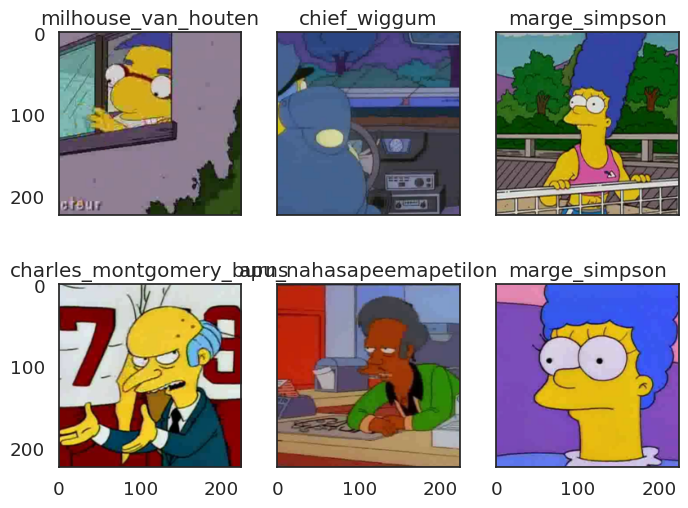

In [ ]:
show_images(val_dataset)

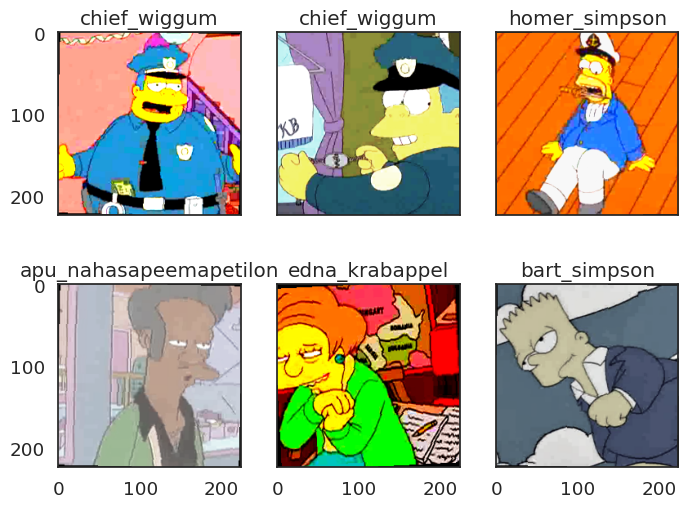

In [ ]:
show_images(train_dataset)

**Создадим DataLoader-ы и функции для обучения**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

В код функции train добавлена строка scheduler.step() для использования шедулера.

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
       # scheduler.step() # шаг шедулера LR

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# **1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.**

In [ ]:
from torchvision.models import resnet18

Результат, полученный при обучнии ResNet 18 с нуля на практике:

Epoch 10 of 10 took 197.904s
  training loss (in-iteration): 	1.826983
  validation loss (in-iteration): 	1.602347
  training accuracy: 			50.28 %
  validation accuracy: 			56.28 %


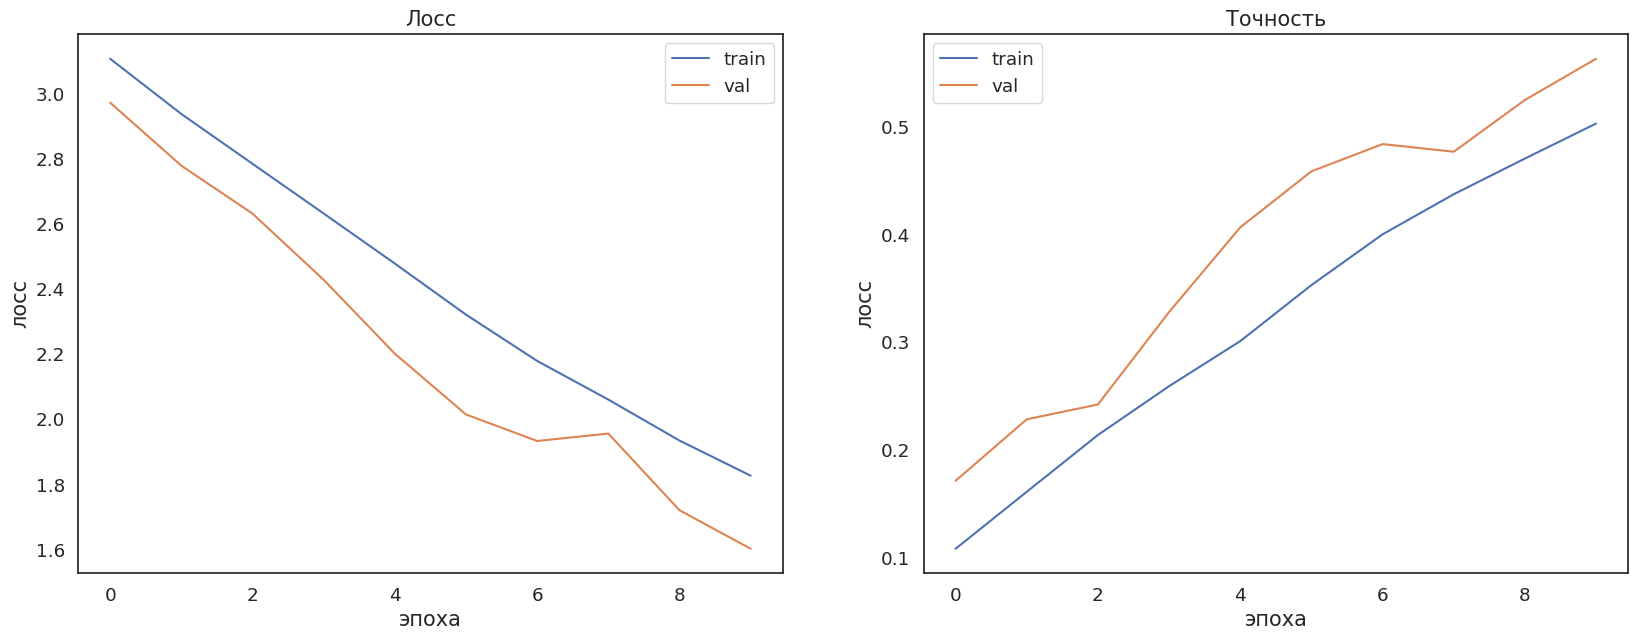

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Эксприменты с LR Schedulers:

Epoch 10 of 10 took 167.401s
  training loss (in-iteration): 	2.029574
  validation loss (in-iteration): 	1.916409
  training accuracy: 			44.32 %
  validation accuracy: 			50.02 %


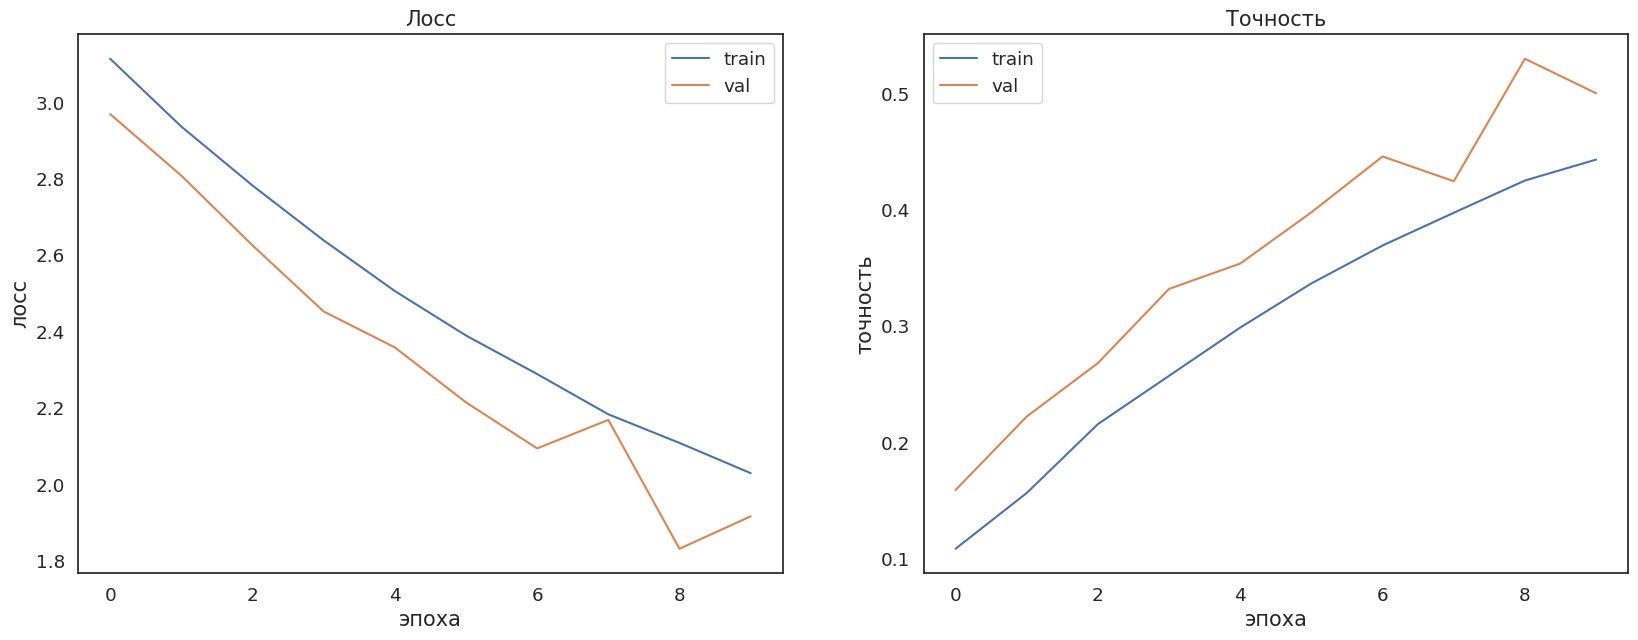

CPU times: user 26min 14s, sys: 1min 43s, total: 27min 58s
Wall time: 28min 17s


In [ ]:
# Шедулер ExponentialLR
%%time
model = resnet18(weights=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Epoch 10 of 10 took 168.200s
  training loss (in-iteration): 	2.518978
  validation loss (in-iteration): 	2.382187
  training accuracy: 			29.72 %
  validation accuracy: 			35.97 %


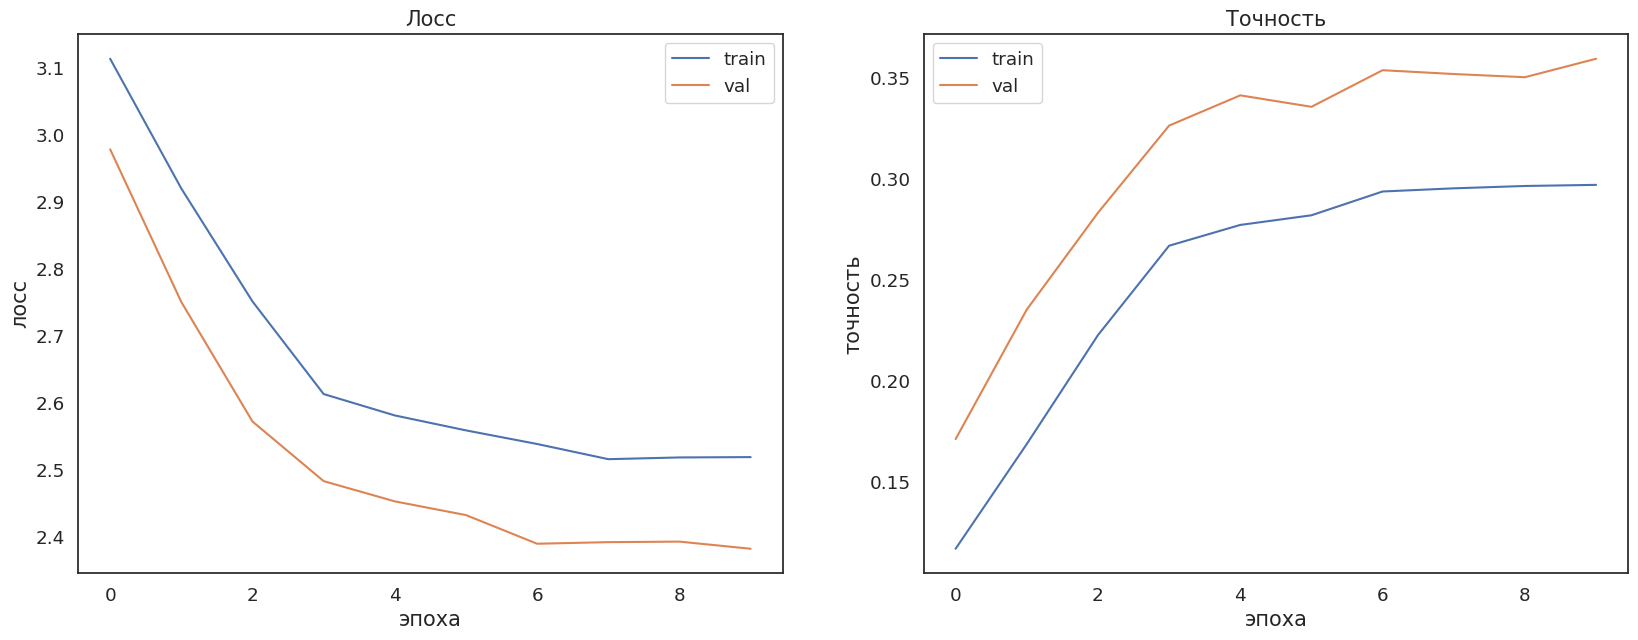

CPU times: user 26min 21s, sys: 1min 36s, total: 27min 57s
Wall time: 28min 8s


In [ ]:
# Шедулер MultiStepLR
%%time
model = resnet18(weights=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,7], gamma=0.1)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Оба эксперимента значительно ухудшили точность на валидационной выборке: ExponentialLR на 6%, MultiStepLR - на 21%. Сами по себе шедулеры не улучшают метрику качества, а работают в комплексе с другими гиперпарамтерами для тонкой настройки.

# **2. Подберите аугментации train данных, при которых итоговое качество на валидации ухудшится.**

Согласно документации Pytorch, модуль v2 работает быстрее и эффективнее, воспользуемся им.

Для ухудшения качества на валидационной выборке сделаем изображения в обучающей выборке менее похожими на оригинальные: изменим их на черно-белые и применим с вероятностью 0,7 отражение по горизонтали.

In [ ]:
from torchvision.transforms import v2

In [ ]:
input_size = 224

train_transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop(input_size),
    v2.Grayscale(3),
    v2.RandomHorizontalFlip(0.7),
    v2.ToTensor(),
])


val_transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop(input_size),
    v2.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform, allow_empty=False,
    is_valid_file=lambda x: x in val_files_path
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 10 of 10 took 140.336s
  training loss (in-iteration): 	1.243097
  validation loss (in-iteration): 	5.683155
  training accuracy: 			67.76 %
  validation accuracy: 			20.33 %


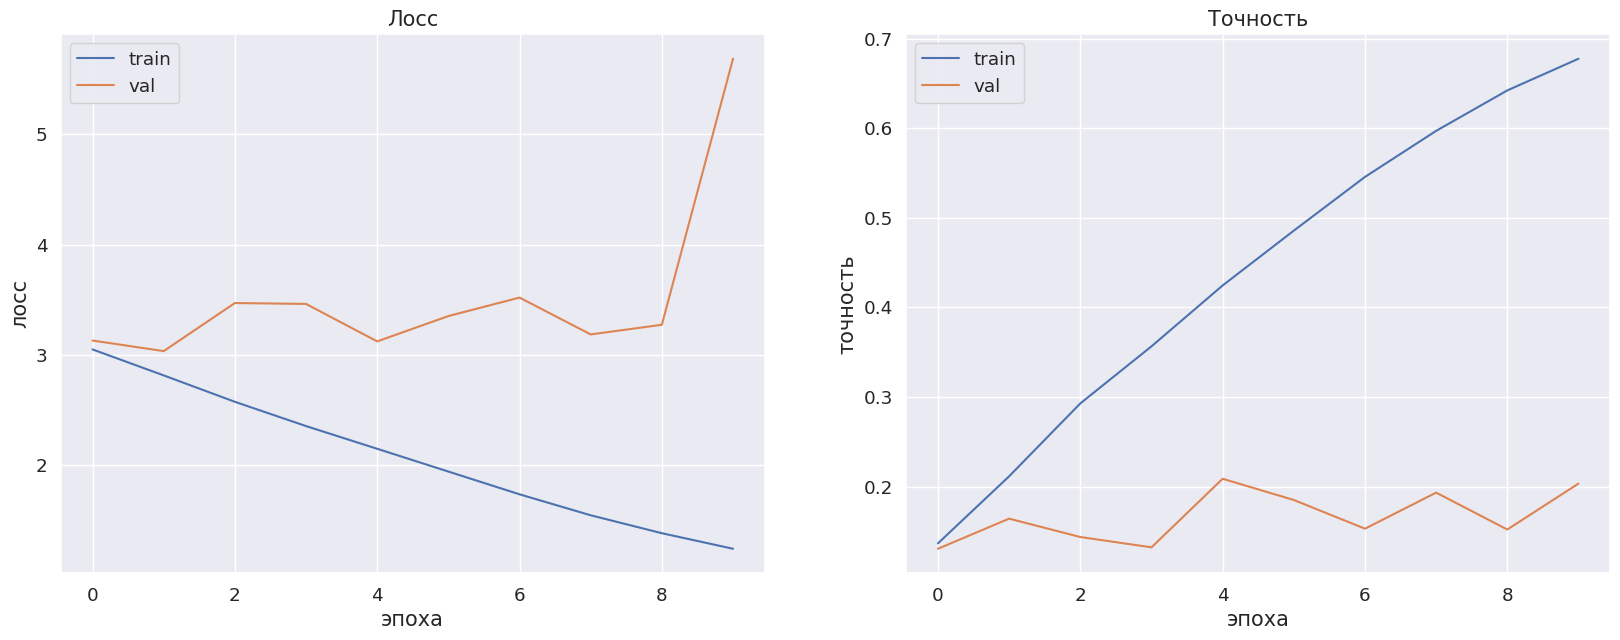

In [ ]:
model = resnet18(weights=None)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Требуемый результат достигнут: точность на обучающей выборке достигла 70%, а на валидационной составила 20% (против 58%, полученных на занятии).

# **3. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и используейте ее как Feature Extractor, Fine Tuning.**

Будем обучать модель EfficientNet.

Виды аугментации изображений оставим такими же, которые были использованы на занятии, а модуль заменим на более новый v2.

In [ ]:
input_size = 224

train_transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop(input_size),
    v2.ColorJitter(0.9, 0.9, 0.9),
    v2.RandomAffine(5),
    v2.ToTensor(),
])


val_transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop(input_size),
    v2.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform, allow_empty=False,
    is_valid_file=lambda x: x in val_files_path
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

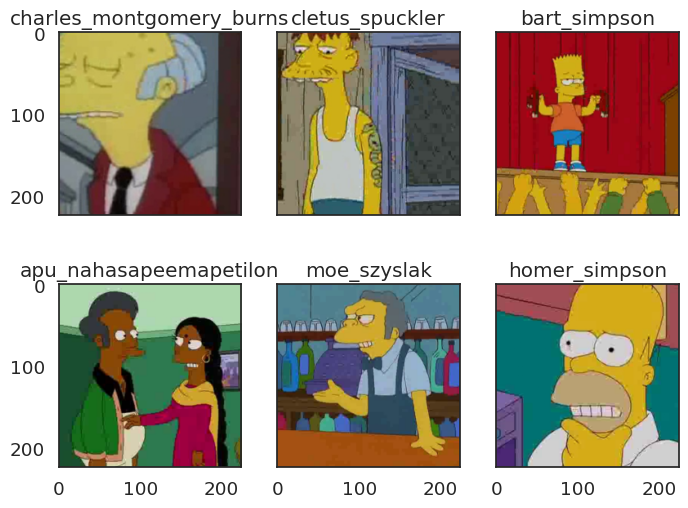

In [ ]:
show_images(val_dataset)

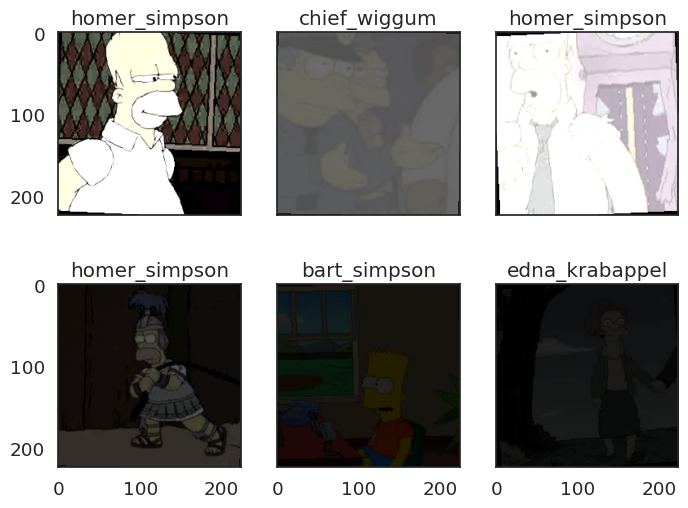

In [ ]:
show_images(train_dataset)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
       # scheduler.step() # шаг шедулера LR

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import efficientnet_b0

Обучение с нуля.

In [ ]:
model = efficientnet_b0(weights=False)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

У модели классификатор состоит из слоя дропаута (его оставим) и линейного слоя (его заменим на новый линейный слой с 42 выходами).

In [ ]:
model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

Epoch 10 of 10 took 200.334s
  training loss (in-iteration): 	1.462443
  validation loss (in-iteration): 	1.118463
  training accuracy: 			61.11 %
  validation accuracy: 			70.58 %


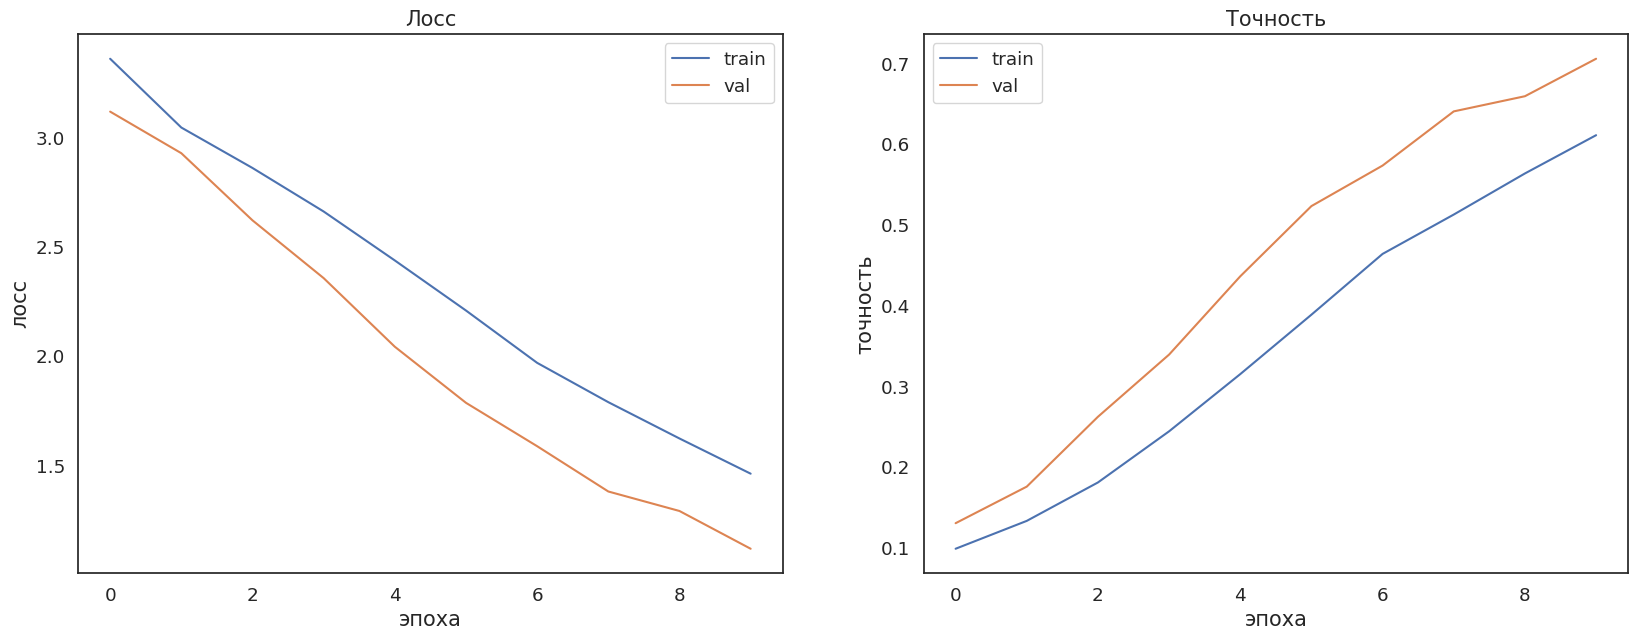

In [ ]:
model.classifier[1] = nn.Linear(1280, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Точность на валидационной выборке достигла 70,58%, и, судя по графику, есть потенциал для ее дальнейшего роста (на графике нет выраженной зоны насыщения).

Использование сети как `Feature Extractor`.

Epoch 10 of 10 took 149.472s
  training loss (in-iteration): 	1.970784
  validation loss (in-iteration): 	1.683630
  training accuracy: 			53.77 %
  validation accuracy: 			62.88 %


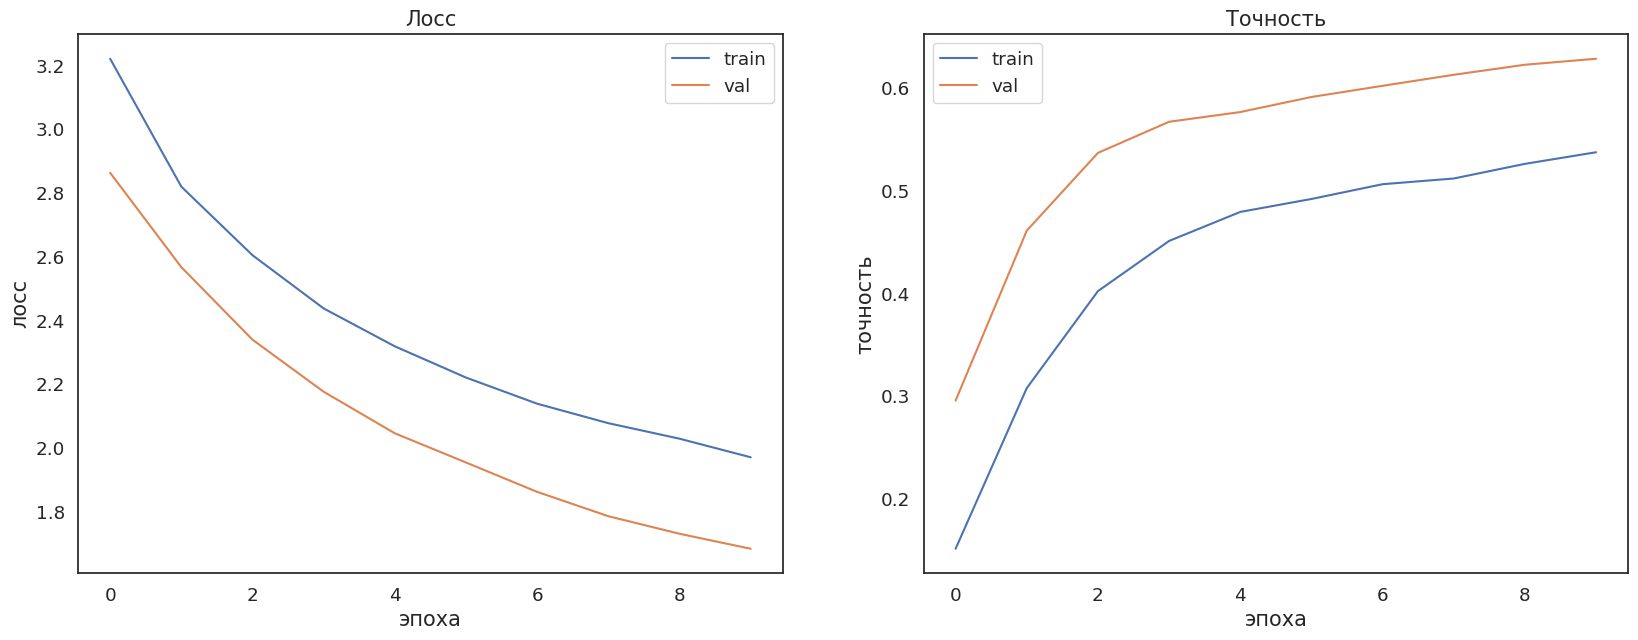

In [ ]:
# возьмём предобученную сеть
fe_model = efficientnet_b0(weights='DEFAULT')

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.classifier[1] = nn.Linear(1280, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Качество на валидационной выборке на 8% меньше, чем было получено при обучении модели с нуля. Т.к. использованы веса, полученные при обучении модели на более объемном и сложном датасете, чем датасет с изображениями Симпсонов (на котором учился только последний слой), то падение точности на валидации может быть следствием переобучения модели.

Использование модели как `FineTuning`.

Epoch 10 of 10 took 201.245s
  training loss (in-iteration): 	0.256559
  validation loss (in-iteration): 	0.220763
  training accuracy: 			93.25 %
  validation accuracy: 			94.26 %


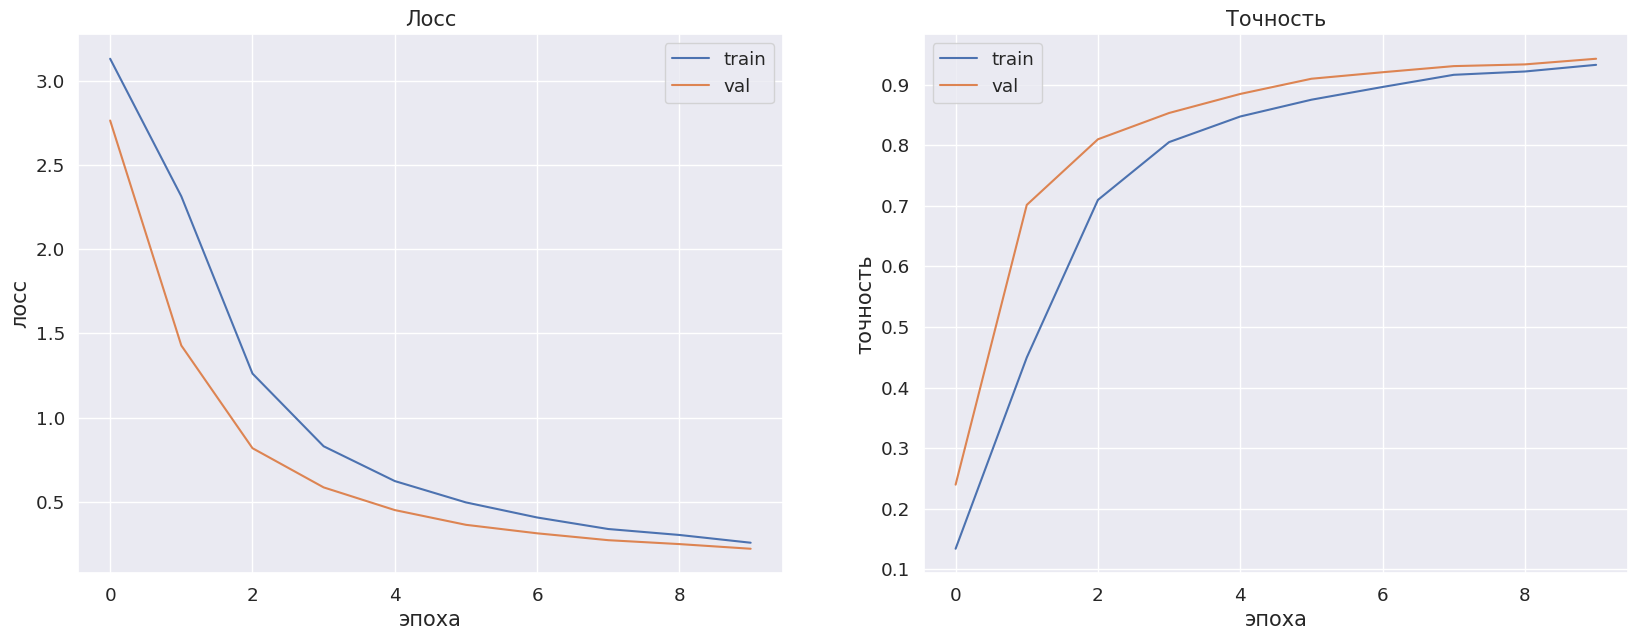

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('efficientnet_b0', efficientnet_b0(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Последний эксперимент дал лучшие результаты (94%-ую точность на валидационной выборке). Это можно объяснить тем, что все слои исходной модели уже обучены на большом датасете, а на небольшом новом обучен не только последний слой, а несколько, что и обеспечило тонкую настройку весов и в итоге повысило точность.  

# **4. Оформите вывод по результатам проведённых экспериментов.**

Все эксперименты проведены, требуемые результаты достигнуты, краткие выводы описаны после каждого задания.